# **Mount Drive**

In [1]:

#Mount Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


vortex = 0;
reduce = 0;

if (vortex ==1):

    !cp "/content/drive/My Drive/vortex_imgs.zip" "vortex_imgs"
    !unzip -uq "vortex_imgs" -d "vortex"

    #Directory Locations
    img_dir = r'/content/vortex/vortex_imgs/imgs/';
    excel_path = r'/content/vortex/vortex_imgs/excel/';

else:
    !cp "/content/drive/My Drive/expanded_imgs.zip" "expanded_imgs"
    !unzip -uq "expanded_imgs" -d "expanded"

    #Directory Locations
    img_dir = r'/content/expanded/expanded_imgs/imgs/';
    excel_path = r'/content/expanded/expanded_imgs/excel/';

Mounted at /content/drive


# **Load Data**

In [2]:
import logging
import numpy as np

# Homomorphic filter class
class HomomorphicFilter:
    """Homomorphic filter implemented with diferents filters and an option to an external filter.
    
    High-frequency filters implemented:
        butterworth
        gaussian
    Attributes:
        a, b: Floats used on emphasis filter:
            H = a + b*H
        
        .
    """

    def __init__(self, a = 0.5, b = 1.5):
        self.a = float(a)
        self.b = float(b)

    # Filters
    def __butterworth_filter(self, I_shape, filter_params):
        P = I_shape[0]/2
        Q = I_shape[1]/2
        U, V = np.meshgrid(range(I_shape[0]), range(I_shape[1]), sparse=False, indexing='ij')
        Duv = (((U-P)**2+(V-Q)**2)).astype(float)
        H = 1/(1+(Duv/filter_params[0]**2)**filter_params[1])
        return (1 - H)

    def __gaussian_filter(self, I_shape, filter_params):
        P = I_shape[0]/2
        Q = I_shape[1]/2
        H = np.zeros(I_shape)
        U, V = np.meshgrid(range(I_shape[0]), range(I_shape[1]), sparse=False, indexing='ij')
        Duv = (((U-P)**2+(V-Q)**2)).astype(float)
        H = np.exp((-Duv/(2*(filter_params[0])**2)))
        return (1 - H)

    # Methods
    def __apply_filter(self, I, H):
        H = np.fft.fftshift(H)
        I_filtered = (self.a + self.b*H)*I
        return I_filtered

    def filter(self, I, filter_params, filter='butterworth', H = None):
        """
        Method to apply homormophic filter on an image
        Attributes:
            I: Single channel image
            filter_params: Parameters to be used on filters:
                butterworth:
                    filter_params[0]: Cutoff frequency 
                    filter_params[1]: Order of filter
                gaussian:
                    filter_params[0]: Cutoff frequency
            filter: Choose of the filter, options:
                butterworth
                gaussian
                external
            H: Used to pass external filter
        """

        #  Validating image
        if len(I.shape) is not 2:
            raise Exception('Improper image')

        # Take the image to log domain and then to frequency domain 
        I_log = np.log1p(np.array(I, dtype="float"))
        I_fft = np.fft.fft2(I_log)

        # Filters
        if filter=='butterworth':
            H = self.__butterworth_filter(I_shape = I_fft.shape, filter_params = filter_params)
        elif filter=='gaussian':
            H = self.__gaussian_filter(I_shape = I_fft.shape, filter_params = filter_params)
        elif filter=='external':
            print('external')
            if len(H.shape) is not 2:
                raise Exception('Invalid external filter')
        else:
            raise Exception('Selected filter not implemented')
        
        # Apply filter on frequency domain then take the image back to spatial domain
        I_fft_filt = self.__apply_filter(I = I_fft, H = H)
        I_filt = np.fft.ifft2(I_fft_filt)
        I = np.exp(np.real(I_filt))-1
        return np.uint8(I)
# End of class HomomorphicFilter

DX 1: BG2782
DX 2: CC7686


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in log1p


(77025, 64, 64, 1) (77025, 2)


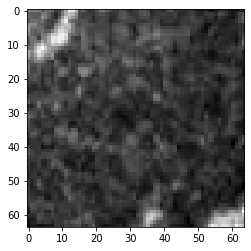

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from glob import glob
import os
import tqdm
from sklearn.model_selection import StratifiedKFold
import pandas as pd;
from random import randint
import random;



#Excel File Name & Path
excel_fn = 'classification.xlsx';
excel_data = pd.ExcelFile(excel_path + excel_fn);
excel_sheet = excel_data.sheet_names;
excel_data = excel_data.parse(excel_sheet[0]);
pid = excel_data["PID"];
dx = excel_data["Classification"] - 1;

#Randomly Choose Test Set
dx_1 = random.choice(np.array(np.where(dx==0)).squeeze());
pid_1 = pid[dx_1];
print('DX 1: ' + pid_1)
dx_2 = random.choice(np.array(np.where(dx==1)).squeeze());
pid_2 = pid[dx_2];
print('DX 2: ' + pid_2)
remove_indices = [];


#Excel File 
excel_fn = 'img_master.xlsx';
excel_data = pd.ExcelFile(excel_path + excel_fn);
excel_sheet = excel_data.sheet_names;
excel_data = excel_data.parse(excel_sheet[0]);
pid = excel_data["PID"];
pid_list = np.arange(0,len(pid)).tolist();
dx = excel_data["Diagnosis"] - 1;



#PID Weights
pid_weights = np.zeros((1,len(pid)));
for i in range(0,len(pid)):
    img_list = glob(r'' + img_dir + pid[i] + '*.jpg');
    pid_weights[0,i] = 1/len(img_list);
pid_weights /= np.sum(pid_weights)


#Inverse Class Weights
ratio_0 = len(dx)/float(np.array(np.where(dx==0)).size);
ratio_1 = len(dx)/float(np.array(np.where(dx==1)).size);
ratio_sum = ratio_0 + ratio_1;
ratio_0 /= ratio_sum;
ratio_1 /= ratio_sum;
class_weights = [ratio_0, ratio_1];

#Homomorphic filtering
homo_filter = HomomorphicFilter(a = 0.75, b = 1.25)

#Create Data
x_data = []
pid_data = [];
y_data = []
x_test = []
pid_test = [];
y_test = []

count = 0;
for idx in range(0,len(pid)):
    all_images = glob(r'' + img_dir + pid[idx] + '*.jpg')
    

    
    #Iterate through Images
    current = 0;
    for image_path in all_images:

        if(reduce ==1 and current ==2):
            break;

        current = current +1;    

        #Preprocess Image
        img = Image.open(image_path);
        img = img.convert('L');
        img = np.array(img).astype(np.float32);



        #Size Invariance
        splits = [9, 13, 17]
        for splits_i in range(0,len(splits)):

            #Extract Patches
            dividers = np.linspace(0, img.shape[0], splits[splits_i]);
            
            for img_i in range(0,len(dividers)-2):
                
                start_i = int(dividers[img_i]);
                end_i = int(dividers[img_i+2]); 
                
                for img_j in range(0,len(dividers)-2):

                    start_j = int(dividers[img_j]);
                    end_j = int(dividers[img_j+2]); 

        
                    #Get Current Patch
                    current_patch = img[start_i:end_i, start_j:end_j];
                    current_patch = np.array(Image.fromarray(current_patch).resize([64,64])).astype(np.float32)
                    
                    #Filter & Normalize
                    current_patch = homo_filter.filter(I=current_patch, filter_params=[30,2])/255.0 - 0.5;
                    #current_patch = current_patch/255.0 - 0.5;
                    
                    

                    if(pid_1 in pid[idx] or pid_2 in pid[idx]):


                        #Add to List
                        x_test += [current_patch]
                        pid_test +=[idx]
                        y_test += [dx[idx]]
                        remove_indices.append(idx);

                    else:

                        #Add to List
                        x_data += [current_patch]
                        pid_data +=[idx]
                        y_data += [dx[idx]]


#Add a fake color channel
x_data = np.array(x_data).reshape(-1, 64, 64, 1)
y_data = np.array(y_data)
pid_data = np.array(pid_data)
x_test = np.array(x_test).reshape(-1, 64, 64, 1)
y_test = np.array(y_test)
y_test = np.eye(2)[y_test]
pid_test = np.array(pid_test)

#Remove Test Patients
remove_indices = np.unique(remove_indices);
for i in range(0, len(remove_indices)):
    pid_list.remove(remove_indices[i]);
pid = pid_list;



#Random Shuffle
train_indices = np.arange(0,len(x_data));
np.random.shuffle(train_indices)



#Training Set
x_train = x_data[train_indices]
y_train = np.eye(2)[y_data[train_indices]]
pid_train = pid_data[train_indices]


#Print
print(x_train.shape, y_train.shape)



#Plot
plt.imshow(x_train[115,:,:,0], cmap='gray')
plt.show();


**Autoencoder for Image Classification**

In [4]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Input, UpSampling2D, Dense, Reshape, Flatten
import tensorflow as tf

def build_autoencoder(input_shape):

    #Input
    input_layer = Input(input_shape)
    x = input_layer
    
    #Compression
    start_filters = 8
    for i in range(4):
        x = Conv2D(start_filters * (2**i), 3, padding='same', activation='relu')(x)
        x = Conv2D(start_filters * (2**i), 3, padding='same', activation='relu')(x)
        x = MaxPool2D()(x)
    
    
    #Bottle Neck
    x = Conv2D(start_filters*(2**4),3, padding='same', activation='relu')(x)
    x = MaxPool2D()(x)
    x = Flatten()(x)
    x = Dense(20, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    x = Reshape((2,2,64))(x)
    x = UpSampling2D()(x)
    x = Conv2D(start_filters*(2**4),3, padding='same', activation='relu')(x)
    
    
    #De-compression
    for i in range(4):
        x = UpSampling2D()(x)
        x = Conv2D(start_filters*(2**(3-i)),3, padding='same', activation='relu')(x)
        x = Conv2D(start_filters*(2**(3-i)),3, padding='same', activation='relu')(x)

    #Output
    output = Conv2D(1, 1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=input_layer, outputs=output)
    return model

autoencoder = create_autoencoder((64, 64, 1))

In [14]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Input, UpSampling2D, Dense, Reshape, Flatten
import tensorflow as tf
from keras.layers.advanced_activations import LeakyReLU


def build_autoencoder(input_shape):

    #Input
    input_layer = Input(input_shape)
    x = input_layer
    
    #Compression
    start_filters = 8
    for i in range(4):
        x = Conv2D(start_filters * (2**i), 3, padding='same', activation=LeakyReLU(alpha=0.01))(x)
        x = Conv2D(start_filters * (2**i), 3, padding='same', activation=LeakyReLU(alpha=0.01))(x)
        x = MaxPool2D()(x)
    
    
    #Bottle Neck
    x = Conv2D(start_filters*(2**4),3, padding='same', activation=LeakyReLU(alpha=0.01))(x)
    x = MaxPool2D()(x)
    x = Flatten()(x)
    x = Dense(20, activation=LeakyReLU(alpha=0.01))(x)
    x = Dense(256, activation=LeakyReLU(alpha=0.01))(x)
    x = Reshape((2,2,64))(x)
    x = UpSampling2D()(x)
    x = Conv2D(start_filters*(2**4),3, padding='same', activation=LeakyReLU(alpha=0.01))(x)
    
    
    #De-compression
    for i in range(4):
        x = UpSampling2D()(x)
        x = Conv2D(start_filters*(2**(3-i)),3, padding='same', activation=LeakyReLU(alpha=0.01))(x)
        x = Conv2D(start_filters*(2**(3-i)),3, padding='same', activation=LeakyReLU(alpha=0.01))(x)

    #Output
    output = Conv2D(1, 1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=input_layer, outputs=output)
    return model



**Create Autoencoder**

In [15]:
autoencoder = create_autoencoder((64, 64, 1))
autoencoder.summary()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 64, 8)         80        
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 64, 64, 8)         584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 16)        1168      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 16)       

**Training Autoencoder**

In [16]:
autoencoder.compile(loss='mse')
autoencoder.fit(x_train, x_train, batch_size=32, epochs=10)

Epoch 1/10
2408/2408 [==============================] - 28s 12ms/step - loss: 0.0316
Epoch 2/10
2408/2408 [==============================] - 28s 12ms/step - loss: 0.0312
Epoch 3/10
2408/2408 [==============================] - 28s 12ms/step - loss: 0.0312
Epoch 4/10
2408/2408 [==============================] - 28s 12ms/step - loss: 0.0312
Epoch 5/10
2408/2408 [==============================] - 28s 12ms/step - loss: 0.0312
Epoch 6/10
2408/2408 [==============================] - 28s 12ms/step - loss: 0.0312
Epoch 7/10
2408/2408 [==============================] - 28s 12ms/step - loss: 0.0312
Epoch 8/10
2408/2408 [==============================] - 28s 12ms/step - loss: 0.0312
Epoch 9/10
2408/2408 [==============================] - 28s 12ms/step - loss: 0.0312
Epoch 10/10
2408/2408 [==============================] - 28s 12ms/step - loss: 0.0312


**Extracting embeddings**

In [17]:
embedding_model = tf.keras.Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('dense').output);

embeddings = embedding_model.predict(x_train);

**Cluster the embeddings**

In [1]:
from sklearn.cluster import KMeans

Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k).fit(embeddings)
    Sum_of_squared_distances.append(km.inertia_)


#Elbow Method
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

NameError: ignored

In [9]:
from sklearn.cluster import KMeans

n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters).fit(embeddings)
clusters = kmeans.labels_



count = np.zeros((len(pid),n_clusters));
for i in range(0, len(pid)):

    idx = pid[i]

    pid_mask = np.where(np.array(pid_data) ==idx)
    cluster = clusters[pid_mask];
    
    for k in range(0, n_clusters):

        count[i,k] = np.sum(cluster==k);



In [5]:

for i in range(0, len(pid)):
    count[i,:] = count[i,:]/np.sum(count[i,:]);

for k in range(0, n_clusters):
    count[:,k] = 100*count[:,k]/(np.max(count[:,k]) - np.min(count[:,k]))

for i in range(0, len(pid)):
    if(dx[i]==0):

        count[i,:] = -1*class_weights[0] *count[i,:]

    else:
        count[i,:] = class_weights[1] *count[i,:]


cluster_sums =np.zeros((1,n_clusters));
for k in range(0, n_clusters):
    cluster_sums[0,k] = np.abs(np.sum(count[:,k]));

sorted_clusters = np.sort(cluster_sums);
print(sorted_clusters)
sorted_20 = sorted_clusters[0,-int(n_clusters/4)]
cluster_idx = np.where(cluster_sums>=sorted_20)[1]

#Pick Out Distinguishable Clusters
mask = np.zeros((0,0))
for i in range(0, len(cluster_idx)):

    idx = cluster_idx[i];

    mask = np.concatenate((np.where(clusters==idx), mask), axis=None) 
mask = np.sort(mask).astype(np.int32);


embeddings_dist = embeddings[mask,:];
embeddings_indices = np.arange(0,embeddings.shape[0])
embeddings_dist_indices = embeddings_indices[mask];




TypeError: ignored

In [4]:
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k).fit(embeddings_dist)
    Sum_of_squared_distances.append(km.inertia_)


#Elbow Method
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

NameError: ignored

**Compare Cluster Labels**

In [12]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters).fit(embeddings_dist)
clusters = kmeans.labels_





**Plot the Clusters**

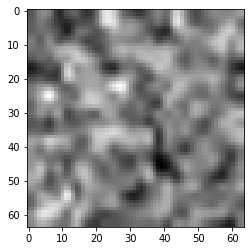

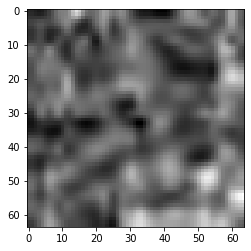

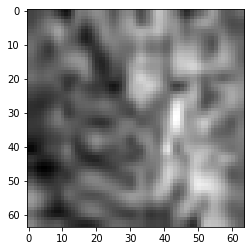

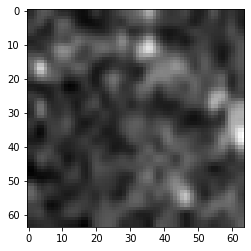

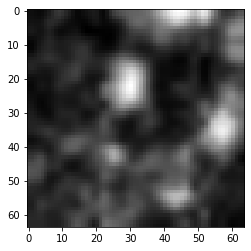

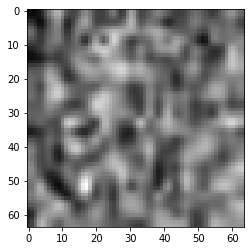

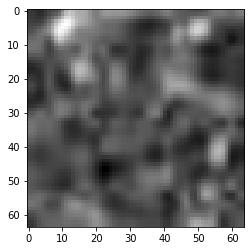

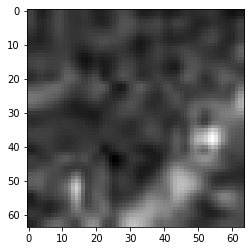

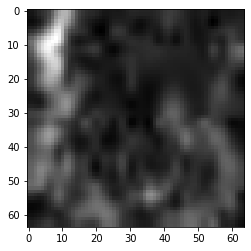

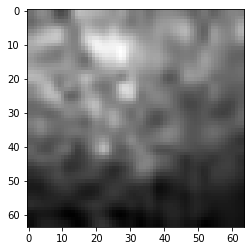

In [14]:

#Select Cluster
k= 0;
indices = np.array(np.where(clusters==k)).astype(np.int32).squeeze();

#Plot 10 Examples
for i in range(0, 10):
    idx = indices[i];
    x_idx = embeddings_dist_indices[idx];

    #Plot
    plt.imshow(x_train[x_idx,:,:,0], cmap='gray')
    plt.show();

**Separate Data**

In [15]:
#Separate Data into Distinct Clusters and Remaining Data
group_labels = 3*np.ones((x_train.shape[0],1));
for k in range(0, n_clusters):

    indices = np.array(np.where(clusters==k)).astype(np.int32).squeeze();
    x_idx = embeddings_dist_indices[indices];  
    group_labels[x_idx,0] = k;


**Save Data**

In [16]:

num = 5;
if(vortex==1):

    string = 'Vortex';
else:
    string = 'Expanded';


#Save Training Data
np.save(r'/content/drive/My Drive/project/X_Data_'+ string + '_' + str(num) + '.npy', x_train);
np.save(r'/content/drive/My Drive/project/Group_Labels_'+ string + '_' + str(num) + '.npy', group_labels);
np.save(r'/content/drive/My Drive/project/Dx_Labels_'+ string + '_' + str(num) + '.npy', y_train);
np.save(r'/content/drive/My Drive/project/PID_Labels_'+ string + '_' + str(num) + '.npy', pid_train);

#Save Testing Data
np.save(r'/content/drive/My Drive/project/X_Data_Test_'+ string + '_' + str(num) + '.npy', x_test);
np.save(r'/content/drive/My Drive/project/Dx_Labels_Test_'+ string + '_' + str(num) + '.npy', y_test);
np.save(r'/content/drive/My Drive/project/PID_Labels_Test_'+ string + '_' + str(num) + '.npy', pid_test);


In [17]:
#Load Files
img_patches = np.load(r'/content/drive/My Drive/project/X_Data_'+ string + '_' + str(num) + '.npy');
groups = np.load(r'/content/drive/My Drive/project/Group_Labels_'+ string + '_' + str(num) + '.npy').squeeze();
dx = np.load(r'/content/drive/My Drive/project/Dx_Labels_'+ string + '_' + str(num) + '.npy');
pid = np.load(r'/content/drive/My Drive/project/PID_Labels_'+ string + '_' + str(num) + '.npy');

print(img_patches.shape)

for k in range(0,4):
#for k in range(0,7):

    indices = np.array(np.where(groups==k)).astype(np.int32).squeeze();

    print('Group ' + str(k) + ': ' + str(len(indices)))


(131625, 64, 64, 1)
Group 0: 16710
Group 1: 17763
Group 2: 17607
Group 3: 79545
